In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
def str2array(string):

    numbers_str = string.strip('[]').split(',')
    array = np.array([int(num) for num in numbers_str])
    return array

In [137]:
# Define a function to load and merge a prediction catalog
def merge_with_predictions(cat, pred_path, filter_name):
    pred = pd.read_csv(pred_path)
    pred = pred.add_suffix(f'_{filter_name}')
    pred.rename(columns={f'id_{filter_name}': 'id_str'}, inplace=True)
    merged = cat.merge(pred, how='inner', right_on=f'id_str', left_on='col1', suffixes=(None, f'_{filter_name}'))
    return merged



# Function to select the correct probabilities based on redshift conditions
def select_probabilities(row):
    conditions = [row['LP_zfinal'] < 1, 1 <= row['LP_zfinal'] < 3, row['LP_zfinal'] >= 3]
    p_feature_choices = [row['p_feature_f150w'], row['p_feature_f277w'], row['p_feature_f444w']]
    p_bar_choices = [row['p_bar_f150w'], row['p_bar_f277w'], row['p_bar_f444w']]
    p_edgeon_choices = [row['p_edgeon_f150w'], row['p_edgeon_f277w'], row['p_edgeon_f444w']]
    p_clump_choices = [row['p_clump_f150w'], row['p_clump_f277w'], row['p_clump_f444w']]
    p_spiral_choices = [row['p_spiral_f150w'], row['p_spiral_f277w'], row['p_spiral_f444w']]
    p_merger_choices = [row['p_merger_f150w'], row['p_merger_f277w'], row['p_merger_f444w']]
    #rf_mag_choices = [row['MAG_MODEL_F150W'], row['MAG_MODEL_F277W'] - 0.6, row['MAG_MODEL_F444W'] - 0.5]

    return (
        np.select(conditions, p_feature_choices, default=np.nan),
        np.select(conditions, p_bar_choices, default=np.nan),
        np.select(conditions, p_edgeon_choices, default=np.nan),
        np.select(conditions, p_clump_choices, default=np.nan),
        np.select(conditions, p_spiral_choices, default=np.nan),
        np.select(conditions, p_merger_choices, default=np.nan),
        #np.select(conditions, rf_mag_choices, default=np.nan)  # Return single value for RF_mag_samples
    )

# Function to parse and clean count arrays from string representation
def parse_count_array(count_str):
    # Remove all non-numeric characters except for commas
    clean_str = re.sub(r'[^\d,]', '', count_str)
    # Split the cleaned string by commas
    return np.array([int(x) for x in clean_str.split(',')])

# Vectorized function to calculate probabilities for all samples in a column
def calculate_probabilities_feature(df, count_column, n_vols):
    return df[count_column].apply(lambda x: parse_count_array(x) / n_vols)

def calculate_probabilities_edge(df, count_column, nvols_column):
    return df.apply(lambda row: parse_count_array(row[count_column]) / parse_count_array(row[nvols_column]), axis=1)

def calculate_probabilities_bar(df, count_column, nfeature_column,nedge_column):
    return df.apply(lambda row: parse_count_array(row[count_column]) / (parse_count_array(row[nfeature_column])-parse_count_array(row[nedge_column])), axis=1)

def calculate_probabilities_clump(df, count_column, nfeature_column,nspiral_column):
    
    return df.apply(lambda row: parse_count_array(row[count_column]) / (parse_count_array(row[nfeature_column])-parse_count_array(row[nspiral_column])), axis=1)

def calculate_probabilities_merger(df, count_column, nfeature_column,nspiral_column,nsmooth_column):
    
    return df.apply(lambda row: parse_count_array(row[count_column]) / (parse_count_array(row[nfeature_column])-parse_count_array(row[nspiral_column])+parse_count_array(row[nsmooth_column])), axis=1)


# Function to fill NaNs and infinities in nested arrays
def fill_invalid_values(arr, fill_value):
    if isinstance(arr, list):
        return [fill_invalid_values(x, fill_value) for x in arr]
    elif isinstance(arr, np.ndarray):
        arr = np.where(np.isnan(arr), fill_value, arr)
        arr = np.where(np.isinf(arr), fill_value, arr)
        return arr
    return arr







In [ ]:
# Load the main catalog
cat_dir = "/Users/marchuertascompany/Documents/data/CEERS/DenseBasis"
cat_name = "CEERS_DR05_adversarial_asinh_4filters_1122_4class_ensemble_v02_stellar_params_morphflag_delta_10points_DenseBasis_galfit_CLASS_STAR_v052_bug.csv"
cat = pd.read_csv(os.path.join(cat_dir,cat_name))


pred_dir = "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/ceers"
# Paths to the prediction catalogs - CHANGE PATHS WHEN DOWNLOADED
pred_paths = {
    'f150w': os.path.join(pred_dir,"F150W_sampling.csv"),
    'f356w': os.path.join(pred_dir,"F356W_sampling.csv"),
    'f444w': os.path.join(pred_dir,"F444W_sampling.csv")
}

# Merge with each prediction catalog
merged_cat = cat.copy()
for filter_name, pred_path in pred_paths.items():
    merged_cat = merge_with_predictions(merged_cat, pred_path, filter_name)

# Remove redundant 'id_str' columns after merging
for filter_name in pred_paths.keys():
    col_name = f'id_str_{filter_name}'
    if col_name in merged_cat.columns:
        merged_cat.drop(columns=[col_name], inplace=True)

# Final merged catalog
merge = merged_cat


N_VOLS = 100
n_samples=100


# Calculate probabilities for each filter and store them in the DataFrame
merge['p_feature_f150w'] = calculate_probabilities_feature(merge, 'feature_count_f150w', np.zeros(n_samples)+N_VOLS)
merge['p_edgeon_f150w'] = calculate_probabilities_edge(merge, 'edgeon_count_f150w','feature_count_f150w')
merge['p_bar_f150w'] = calculate_probabilities_bar(merge, 'bar_count_f150w', 'feature_count_f150w','edgeon_count_f150w')
#merge['p_clump_f150w'] = calculate_probabilities_clump(merge, 'clump_count_f150w', 'feature_count_f150w','spiral_count_f150w')
#merge['p_spiral_f150w'] = calculate_probabilities_bar(merge, 'spiral_count_f150w', 'feature_count_f150w','edgeon_count_f150w')
#merge['p_merger_f150w'] = calculate_probabilities_merger(merge, 'merger_count_f150w', 'feature_count_f150w','spiral_count_f150w','smooth_count_f150w')

merge['p_feature_f277w'] = calculate_probabilities_feature(merge, 'feature_count_f356w', np.zeros(n_samples)+N_VOLS)
merge['p_edgeon_f277w'] = calculate_probabilities_edge(merge, 'edgeon_count_f356w', 'feature_count_f277w')
merge['p_bar_f277w'] = calculate_probabilities_bar(merge, 'bar_count_f356w', 'feature_count_f277w','edgeon_count_f277w')
#merge['p_clump_f277w'] = calculate_probabilities_clump(merge, 'clump_count_f356w', 'feature_count_f277w','spiral_count_f277w')
#merge['p_spiral_f277w'] = calculate_probabilities_bar(merge, 'spiral_count_f356w', 'feature_count_f277w','edgeon_count_f277w')
#merge['p_merger_f277w'] = calculate_probabilities_merger(merge, 'merger_count_f356w', 'feature_count_f277w','spiral_count_f277w','smooth_count_f277w')


merge['p_feature_f444w'] = calculate_probabilities_feature(merge, 'feature_count_f444w', np.zeros(n_samples)+N_VOLS)
merge['p_edgeon_f444w'] = calculate_probabilities_edge(merge, 'edgeon_count_f444w', 'feature_count_f444w')
merge['p_bar_f444w'] = calculate_probabilities_bar(merge, 'bar_count_f444w', 'feature_count_f150w','edgeon_count_f150w')
#merge['p_clump_f444w'] = calculate_probabilities_clump(merge, 'clump_count_f444w', 'feature_count_f444w','spiral_count_f444w')
#merge['p_spiral_f444w'] = calculate_probabilities_bar(merge, 'spiral_count_f444w', 'feature_count_f444w','edgeon_count_f444w')
#merge['p_merger_f444w'] = calculate_probabilities_merger(merge, 'merger_count_f444w', 'feature_count_f444w','spiral_count_f444w','smooth_count_f444w')



# Apply the function to each row and store the results
merge[['p_feature_samples', 'p_bar_samples', 'p_edgeon_samples']] = merge.apply(
    lambda row: pd.Series(select_probabilities(row)), axis=1
)


# Ensure the p_bar_samples and p_feature_samples columns are lists/arrays
merge['p_bar_samples'] = merge['p_bar_samples'].apply(lambda x: np.array(x))
merge['p_feature_samples'] = merge['p_feature_samples'].apply(lambda x: np.array(x))
#merge['p_merger_samples'] = merge['p_merger_samples'].apply(lambda x: np.array(x))
#merge['p_spiral_samples'] = merge['p_spiral_samples'].apply(lambda x: np.array(x))
#merge['p_clump_samples'] = merge['p_clump_samples'].apply(lambda x: np.array(x))
merge['p_edgeon_samples'] = merge['p_edgeon_samples'].apply(lambda x: np.array(x))

def robust_mean(arr):
    finite_arr = arr[np.isfinite(arr)]  # Filter out inf and -inf values
    if finite_arr.size == 0:
        return np.nan  # If all values are non-finite, return NaN
    return np.nanmean(finite_arr)  # Compute mean ignoring NaN values

merge['p_bar_mean'] = merge['p_bar_samples'].apply(lambda x: robust_mean(np.array(x)))
merge['p_feature_mean'] = merge['p_feature_samples'].apply(lambda x: robust_mean(np.array(x)))
#merge['p_spiral_mean'] = merge['p_spiral_samples'].apply(lambda x: robust_mean(np.array(x)))
#merge['p_clump_mean'] = merge['p_clump_samples'].apply(lambda x: robust_mean(np.array(x)))
#merge['p_merger_mean'] = merge['p_merger_samples'].apply(lambda x: robust_mean(np.array(x)))
merge['p_edgeon_mean'] = merge['p_edgeon_samples'].apply(lambda x: robust_mean(np.array(x)))


# Remove the specified columns
columns_to_remove = [
    'p_bar_samples', 
    'p_feature_samples', 
   'p_edgeon_samples'
]

def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

#merge = merge.drop(columns=columns_to_remove)

# Optimize data types
merge = optimize_dtypes(merge)

#rf_mag_choices = [row['MAG_MODEL_F150W'], row['MAG_MODEL_F277W'] - 0.6, row['MAG_MODEL_F444W'] - 0.5]
rf_mag = merge.F150W_MAG.values
z=merge.LP_zfinal.values
rf_mag[(z>1)&(z<3)]=merge.F356W_MAG.values[(z>1)&(z<3)]-0.6
rf_mag[(z>3)]=merge.F444W_MAG.values[(z>3)]-0.5

merge['RF_mag']=rf_mag

In [135]:
path = '/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/ceers'

FILTER =150


N_BINS_z = 5
bins_z = [0, 1,1.5, 2,2.5, 3,3.5, 4, 4.5,5]

N_BINS_M = 5
bins_M = [7., 8. ,9., 10., 11., 12.]

N_VOLS = 100
N_RUNS = 100

result = pd.read_csv(os.path.join(path,f"F{FILTER}W_sampling.csv"))

feature_count = result['feature_count'].values
edgeon_count = result['edgeon_count'].values
bar_count = result['bar_count'].values

z50 = result['zfit_50'].values
M50 = result['logM_50'].values
q = result['q'].values


feature_thresholds = [0.5]
bar_thresholds = [0.5]

result 

,Unnamed: 0,id,zfit_50,zfit_16,zfit_84,q,q_err,logM_50,logM_16,logM_84,feature_count,edgeon_count,bar_count
0,0,12363,0.72453,0.63153,0.83053,0.5782,0.0404,7.6435,6.8915,7.8705,"[27,13,26,18,15,15,24,19,33,19,19,21,12,37,40,...","[6,3,5,3,3,3,4,6,11,2,3,3,4,6,3,8,5,3,9,10,4,8...","[4,5,7,6,6,5,7,6,9,6,8,6,2,12,13,3,3,2,5,6,4,3..."
1,1,1456,0.26653,0.25253,0.28553,0.7295,0.0013,9.7145,9.6265,9.8075,"[42,36,24,40,37,25,29,44,20,35,35,15,21,32,31,...","[8,2,2,13,6,6,1,5,3,0,2,2,3,6,5,4,4,0,3,0,6,4,...","[15,9,5,10,11,7,10,12,2,13,9,4,5,9,9,10,14,8,5..."
2,2,167,6.93953,6.91853,6.94353,0.1943,0.2457,8.3135,8.3115,8.6555,"[13,27,18,25,17,26,18,21,21,20,21,28,20,16,22,...","[7,7,5,8,3,12,7,6,4,4,6,4,6,10,4,11,2,6,11,7,6...","[3,3,4,3,4,3,3,2,4,4,3,5,2,4,5,4,1,6,8,12,0,2,..."
3,3,7618,1.43753,1.41253,1.43853,0.4487,0.0009,10.7295,10.7285,10.7535,"[25,40,18,36,27,31,25,17,16,45,29,10,11,28,12,...","[6,21,6,18,5,11,8,7,11,8,17,3,3,8,6,6,4,6,5,6,...","[5,2,2,4,5,4,7,5,0,7,5,2,3,7,2,2,1,7,4,1,3,3,6..."
4,4,2476,2.88853,2.64353,3.15553,0.4829,0.0319,8.9825,8.7565,9.1015,"[11,10,12,7,13,5,19,17,7,6,13,17,16,14,5,16,15...","[3,1,3,0,2,1,7,1,1,0,5,3,3,4,0,1,3,1,7,0,1,2,1...","[1,0,2,2,5,0,2,4,1,3,1,2,6,2,0,2,4,2,1,1,0,1,4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15680,15680,13616,1.06053,0.93753,1.08653,0.2782,0.0017,9.2255,9.1575,9.2765,"[15,21,28,18,21,22,12,18,20,22,20,20,21,19,28,...","[11,17,21,13,17,18,11,13,14,16,15,16,18,15,23,...","[1,0,3,2,1,1,1,1,0,2,0,0,0,0,2,1,3,3,2,0,2,2,1..."
15681,15681,20752,2.04553,1.98753,2.07053,0.9453,0.0035,10.8765,10.8555,10.9345,"[26,13,56,73,19,31,26,19,18,21,21,39,21,39,31,...","[1,0,0,4,2,0,0,2,0,0,2,0,0,2,0,0,1,0,0,0,0,2,5...","[1,1,4,5,1,2,1,0,1,0,0,4,0,11,3,0,2,0,0,1,1,0,..."
15682,15682,3112,3.53953,3.48853,3.57153,0.4658,0.0402,8.5245,8.4035,8.8015,"[19,1,7,11,18,9,16,7,27,27,9,15,23,1,7,14,7,9,...","[5,0,0,1,1,0,6,1,6,4,3,1,5,0,2,1,0,2,0,2,6,2,0...","[1,0,0,0,0,2,1,2,2,3,2,1,3,0,2,3,1,1,1,1,2,1,0..."
15683,15683,22966,2.00053,1.85653,2.09653,0.3440,0.0090,9.1375,8.8805,9.2465,"[24,20,12,20,24,25,17,25,15,32,18,24,29,18,29,...","[11,10,3,15,12,7,8,8,7,11,10,12,14,6,16,9,20,1...","[6,4,0,1,5,4,2,4,1,6,3,3,1,4,1,8,1,2,2,3,7,4,5..."


/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_50204/2108969130.py:22: RuntimeWarning: divide by zero encountered in true_divide
  bar_fraction = num_barred_disks / num_disks
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_50204/2108969130.py:22: RuntimeWarning: invalid value encountered in true_divide
  bar_fraction = num_barred_disks / num_disks
/Users/marchuertascompany/soft/miniforge3/envs/tfenv23/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


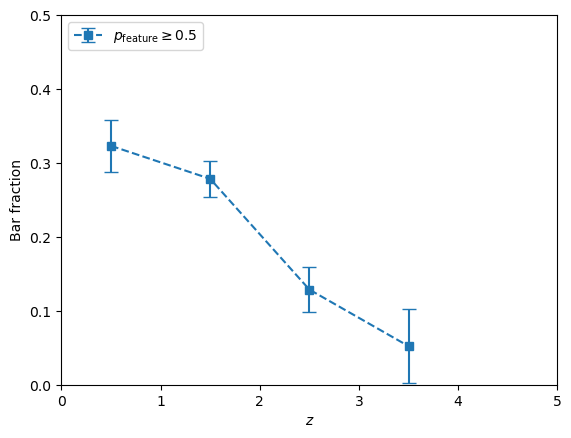

In [8]:
# different p_feature, binned by z
num_disks = np.zeros((3, N_BINS_z, N_RUNS))
num_barred_disks = np.zeros((1, N_BINS_z, N_RUNS))

for k in range(len(feature_thresholds)):
    for i in range(len(result)):
        for j in range(N_BINS_z):
            if (z50[i] >= bins_z[j]) & (z50[i] < bins_z[j+1]):
                feature = str2array(feature_count[i])
                edgeon = str2array(edgeon_count[i])
                bar = str2array(bar_count[i])

                # is_disk = (feature >= 0.3*N_VOLS) & (edgeon <= 0.5*feature) & (q[i] >= 0.5)
                is_disk = (feature >= feature_thresholds[k]*N_VOLS) & (feature-edgeon >= 15) & (q[i] >= 0.5)
                num_disks[k,j,:] += is_disk.astype(int)

                is_barred_disk = is_disk & (bar >= 0.5*(feature-edgeon))
                num_barred_disks[k,j,:] += is_barred_disk.astype(int)
            
                break

bar_fraction = num_barred_disks / num_disks
err = np.sqrt(np.sum(bar_fraction*(1-bar_fraction)/num_disks, axis=2)/N_RUNS**2 + np.var(bar_fraction, axis=2))

bin_centers = [(bins_z[i] + bins_z[i+1]) / 2 for i in range(N_BINS_z)]

# plt.plot(bin_centers, np.mean(bar_fraction, axis=1), linestyle='-')
# plt.scatter(bin_centers, np.mean(bar_fraction, axis=1), marker='s')
plt.figure()
for k in range(len(feature_thresholds)):
    plt.errorbar(bin_centers, np.mean(bar_fraction[k,:,:], axis=1), yerr=err[k,:], 
                 fmt='--s', capsize = 5, 
                 label=r'$p_\mathrm{feature}\geq%.1f$'%feature_thresholds[k])
plt.xticks(bins_z)
plt.xlabel(r"$z$")
plt.ylabel("Bar fraction")
plt.ylim((0, 0.5))
plt.legend(loc='upper left')
#plt.savefig(f'F{FILTER}W_pred/f_bar_z_p_feature_F{FILTER}W.png')
plt.show()

In [96]:
cat_dir = "/Users/marchuertascompany/Documents/data/CEERS/DenseBasis"
cat_name = "CEERS_DR05_adversarial_asinh_4filters_1122_4class_ensemble_v02_stellar_params_morphflag_delta_10points_DenseBasis_galfit_CLASS_STAR_v052_bug.csv"

cat = pd.read_csv(os.path.join(cat_dir,cat_name))

merged = cat.merge(result, how='inner', right_on=f'id', left_on='col1')

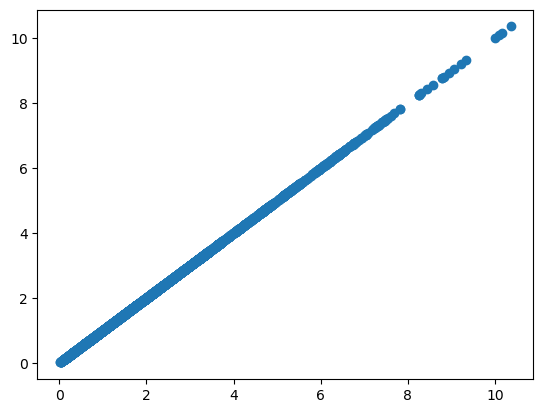

In [97]:
plt.scatter(merged.zfit_50_y,merged.zfit_50_x)


In [91]:
for col in merged.columns:
    print(col)

Unnamed: 0.6
col1
Unnamed: 0.5
Unnamed: 0.4
Unnamed: 0.3
Unnamed: 0.2
col1_1
col1_1a
Unnamed: 0.1
Unnamed: 0_x
ID_1
ID_2
CATID_1
ID_V0P2
MPTID
RA_1
DEC_1
X
Y
FIELD_2
ARRAY_SW
ARRAY_LW
APCORR
APCORR_APER
KRON_RADIUS
A_IMAGE
B_IMAGE
THETA_IMAGE
RH_F200W
FWHM_F200W
FLUX_115
FLUXERR_115
FLUX_150
FLUXERR_150
FLUX_200
FLUXERR_200
FLUX_277
FLUXERR_277
FLUX_356
FLUXERR_356
FLUX_410
FLUXERR_410
FLUX_444
FLUXERR_444
FLUX_606
FLUXERR_606
FLUX_814
FLUXERR_814
FLUX_105
FLUXERR_105
FLUX_125
FLUXERR_125
FLUX_140
FLUXERR_140
FLUX_160
FLUXERR_160
FLUX_115_APER
FLUXERR_115_APER
FLUX_150_APER
FLUXERR_150_APER
FLUX_200_APER
FLUXERR_200_APER
FLUX_277_APER
FLUXERR_277_APER
FLUX_356_APER
FLUXERR_356_APER
FLUX_410_APER
FLUXERR_410_APER
FLUX_444_APER
FLUXERR_444_APER
FLUX_606_APER
FLUXERR_606_APER
FLUX_814_APER
FLUXERR_814_APER
FLUX_105_APER
FLUXERR_105_APER
FLUX_125_APER
FLUXERR_125_APER
FLUX_140_APER
FLUXERR_140_APER
FLUX_160_APER
FLUXERR_160_APER
sph_f200w_mean
sph_f200w_std
disk_f200w_mean
disk_f200w_std
i

In [95]:
print(cat.col1)
print(len(cat))

0            0
1            1
2            2
3            3
4            4
         ...  
24315    24315
24316    24316
24317    24317
24318    24318
24319    24319
Name: col1, Length: 24320, dtype: int64
24320


[[[ 8. 12. 11. 13.  9. 10. 12.  9. 10. 10.  7.  7.  8.  9.  8.  9. 11.
   12. 13.  5. 14. 10. 11. 12. 14.  8. 13. 13.  8. 10. 11.  8. 11.  9.
    9. 12.  7. 10.  7. 10.  8.  8.  9. 13. 11.  7. 11.  8.  8. 10. 10.
   10. 10. 12.  8. 15. 10. 10.  7.  9. 13. 12. 11.  8. 12. 12.  7.  5.
   12.  9.  5. 10. 15. 10.  7.  9. 10.  9. 10. 12. 11.  5.  8. 10.  6.
   11. 12. 10.  9. 12. 11. 10. 10. 10.  8. 11. 12. 10.  9. 13.]
  [27. 22. 26. 34. 28. 26. 25. 24. 31. 29. 31. 23. 30. 31. 23. 29. 28.
   31. 27. 30. 27. 32. 28. 25. 29. 30. 27. 32. 27. 31. 30. 29. 26. 27.
   28. 26. 28. 25. 31. 24. 26. 27. 31. 30. 26. 24. 31. 26. 28. 34. 28.
   31. 29. 31. 30. 31. 27. 28. 27. 30. 31. 28. 28. 34. 25. 30. 29. 28.
   24. 31. 29. 23. 24. 26. 26. 27. 29. 26. 27. 32. 30. 25. 27. 27. 28.
   30. 26. 30. 27. 26. 27. 31. 26. 29. 21. 33. 30. 25. 26. 29.]
  [36. 33. 38. 38. 41. 36. 38. 36. 37. 37. 38. 36. 38. 35. 39. 39. 40.
   36. 38. 40. 32. 36. 34. 38. 39. 37. 37. 36. 37. 38. 35. 34. 38. 36.
   37. 38. 36. 32. 3

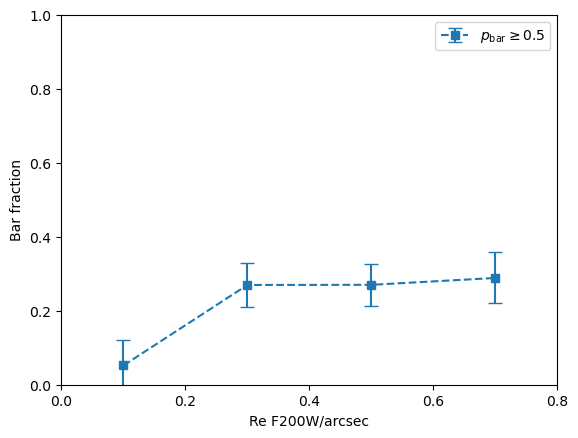

1
4
0
3
1
2
5
3
3
3
4
2
3
2
3
0
5
4
2
2
3
2
3
3
4
3
3
3
1
2
2
3
4
2
3
2
1
2
4
4
4
3
4
1
2
3
3
4
3
4
1
3
4
3
3
3
4
1
3
2
5
2
2
3
2
3
2
3
3
4
3
2
3
2
2
3
3
3
5
4
2
3
3
3
1
2
3
4
0
2
2
3
4
2
2
3
0
4
3
4
0
2
2
0
2
3
2
4
3
3
3
1
4
2
3
1
3
3
1
3
2
2
2
3
1
3
1
3
2
3
3
4
4
3
1
4
1
4
3
3
3
1
2
4
4
4
3
2
3
0
2
2
2
3
3
4
3
2
2
3
3
3
3
4
3
0
3
2
3
4
2
4
3
4
4
3
1
0
3
4
2
3
1
1
2
4
3
3
4
3
1
4
2
2
1
3
2
3
3
2
3
2
2
3
3
3
3
3
3
2
4
3
3
4
3
4
3
2
0
4
3
3
4
3
4
3
3
4
2
1
3
3
3
2
3
3
3
2
3
4
4
2
0
2
4
3
3
3
3
3
3
3
3
3
1
0
5
3
4
3
3
3
1
3
3
1
2
3
2
4
3
2
3
3
2
0
3
2
3
2
4


/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_50204/1905564322.py:89: RuntimeWarning: invalid value encountered in true_divide
  bar_fraction = num_barred_disks / num_disks


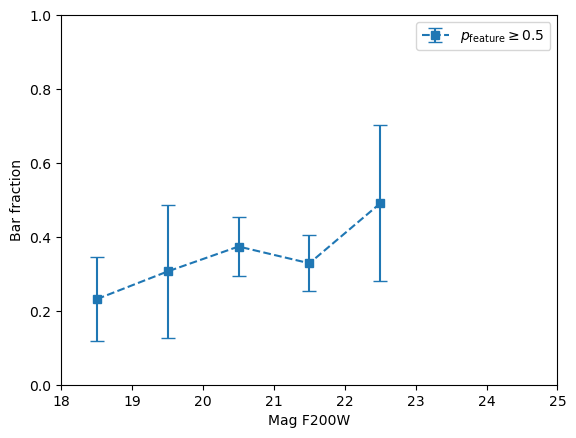

In [112]:


#result = result[(result['zfit_50'] <= 1.) & (result['logM_50'] > 10.) & (result['logM_50'] < 12.)]
sel = merged.query('zfit_50_y<1.2 & logM_50_y>10 & logM_50_y<11')
# result = result[(result['zfit_50'] <= 1.) & (result['logM_50'] > 10.) & (result['logM_50'] < 11.)]


feature_count = sel['feature_count'].values
edgeon_count = sel['edgeon_count'].values
bar_count = sel['bar_count'].values
q = sel['q'].values
id = sel['id'].values

N_BINS_mag = 7
bins_mag = [18,19,20, 21, 22, 23, 24, 25]

N_BINS_Re = 4
bins_Re = [0., 0.2, 0.4, 0.6, 0.8]


mag_F200W = sel['F150W_MAG'].values

Re_F200W = sel['F150W_RE'].values

feature_thresholds = [0.5]
bar_thresholds = [0.5]

# z<1, binned by mag_F200W, varying p_bar threshold
num_disks = np.zeros((1, N_BINS_Re, N_RUNS))
num_barred_disks = np.zeros((1, N_BINS_Re, N_RUNS))

for k in range(1):
    for i in range(len(sel)):
        for j in range(N_BINS_Re):
            if (Re_F200W[i] >= bins_Re[j]) & (Re_F200W[i] < bins_Re[j+1]):
                feature = str2array(feature_count[i])
                edgeon = str2array(edgeon_count[i])
                bar = str2array(bar_count[i])

                # is_disk = (feature >= 0.3*N_VOLS) & (edgeon <= 0.5*feature) & (q[i] >= 0.5)
                is_disk = (feature >= 0.3*N_VOLS) & (feature-edgeon >= 15) & (q[i] >= 0.5)
                num_disks[k,j,:] += is_disk.astype(int)

                is_barred_disk = is_disk & (bar >= bar_thresholds[k]*(feature-edgeon))
                num_barred_disks[k,j,:] += is_barred_disk.astype(int)
            
                #break
print(num_disks, flush=True)
bar_fraction = num_barred_disks / num_disks
err = np.sqrt(np.sum(bar_fraction*(1-bar_fraction)/num_disks, axis=2)/N_RUNS**2 + np.var(bar_fraction, axis=2))

bin_centers = [(bins_Re[i] + bins_Re[i+1]) / 2 for i in range(N_BINS_Re)]

plt.figure()
for k in range(1):
    plt.errorbar(bin_centers, np.mean(bar_fraction[k,:,:], axis=1), yerr=err[k,:], 
                    fmt='--s', capsize = 5, 
                    label=r'$p_\mathrm{bar}\geq%.1f$'%bar_thresholds[k])
plt.xticks(bins_Re)
plt.xlabel("Re F200W/arcsec")
plt.ylabel("Bar fraction")
plt.ylim((0, 1.))
plt.legend(loc='upper right')
#plt.savefig(f'bar_estimate/f_bar_F200W_Re_p_bar.png')
plt.show()


# z<1, binned by mag_F200W, varying p_feature threshold
num_disks = np.zeros((1, N_BINS_mag, N_RUNS))
num_barred_disks = np.zeros((1, N_BINS_mag, N_RUNS))

for k in range(1):
    for i in range(len(sel)):
        for j in range(N_BINS_mag):
            #print(j)
            #print(mag_F200W[i])
            if (mag_F200W[i] >= bins_mag[j]) & (mag_F200W[i] < bins_mag[j+1]):
                feature = str2array(feature_count[i])
                edgeon = str2array(edgeon_count[i])
                bar = str2array(bar_count[i])

                # is_disk = (feature >= 0.3*N_VOLS) & (edgeon <= 0.5*feature) & (q[i] >= 0.5)
                is_disk = (feature >= feature_thresholds[k]*N_VOLS) & (feature-edgeon >= 15) & (q[i] >= 0.5)
                num_disks[k,j,:] += is_disk.astype(int)
                print(j)
                is_barred_disk = is_disk & (bar >= 0.5*(feature-edgeon))
                num_barred_disks[k,j,:] += is_barred_disk.astype(int)
            
                #break

bar_fraction = num_barred_disks / num_disks
err = np.sqrt(np.sum(bar_fraction*(1-bar_fraction)/num_disks, axis=2)/N_RUNS**2 + np.var(bar_fraction, axis=2))

bin_centers = [(bins_mag[i] + bins_mag[i+1]) / 2 for i in range(N_BINS_mag)]

plt.figure()
for k in range(1):
    plt.errorbar(bin_centers, np.mean(bar_fraction[k,:,:], axis=1), yerr=err[k,:], 
                    fmt='--s', capsize = 5, 
                    label=r'$p_\mathrm{feature}\geq%.1f$'%feature_thresholds[k])
plt.xticks(bins_mag)
plt.xlabel("Mag F200W")
plt.ylabel("Bar fraction")
plt.ylim((0, 1.))
plt.legend(loc='upper right')
plt.show()
#plt.savefig(f'bar_estimate/f_bar_F200W_mag_p_feature.png')

/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_50204/3383188857.py:31: RuntimeWarning: invalid value encountered in true_divide
  bar_fraction = num_barred_disks / num_disks


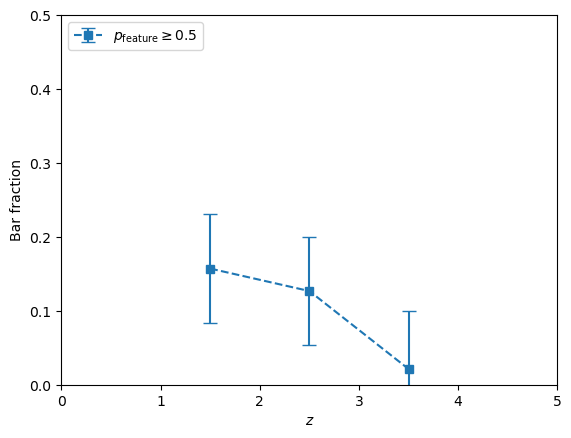

In [134]:
# different p_feature, binned by z
num_disks = np.zeros((1, N_BINS_z, N_RUNS))
num_barred_disks = np.zeros((1, N_BINS_z, N_RUNS))

sel = merged.query('zfit_50_y<5 & logM_50_y>10 & logM_50_y<11 and F150W_MAG>22.5 and F150W_RE<0.4 ')

z50 = sel.zfit_50_y.values
feature_count = sel['feature_count'].values
edgeon_count = sel['edgeon_count'].values
bar_count = sel['bar_count'].values
q = sel['q'].values
id = sel['id'].values

for k in range(len(feature_thresholds)):
    for i in range(len(sel)):
        for j in range(N_BINS_z):
            if (z50[i] >= bins_z[j]) & (z50[i] < bins_z[j+1]):
                feature = str2array(feature_count[i])
                edgeon = str2array(edgeon_count[i])
                bar = str2array(bar_count[i])

                # is_disk = (feature >= 0.3*N_VOLS) & (edgeon <= 0.5*feature) & (q[i] >= 0.5)
                is_disk = (feature >= feature_thresholds[k]*N_VOLS) & (feature-edgeon >= 15) & (q[i] >= 0.5)
                num_disks[k,j,:] += is_disk.astype(int)

                is_barred_disk = is_disk & (bar >= 0.5*(feature-edgeon))
                num_barred_disks[k,j,:] += is_barred_disk.astype(int)
            
                break

bar_fraction = num_barred_disks / num_disks
err = np.sqrt(np.sum(bar_fraction*(1-bar_fraction)/num_disks, axis=2)/N_RUNS**2 + np.var(bar_fraction, axis=2))

bin_centers = [(bins_z[i] + bins_z[i+1]) / 2 for i in range(N_BINS_z)]

# plt.plot(bin_centers, np.mean(bar_fraction, axis=1), linestyle='-')
# plt.scatter(bin_centers, np.mean(bar_fraction, axis=1), marker='s')
plt.figure()
for k in range(len(feature_thresholds)):
    plt.errorbar(bin_centers, np.mean(bar_fraction[k,:,:], axis=1), yerr=err[k,:], 
                 fmt='--s', capsize = 5, 
                 label=r'$p_\mathrm{feature}\geq%.1f$'%feature_thresholds[k])
plt.xticks(bins_z)
plt.xlabel(r"$z$")
plt.ylabel("Bar fraction")
plt.ylim((0, 0.5))
plt.legend(loc='upper left')
#plt.savefig(f'F{FILTER}W_pred/f_bar_z_p_feature_F{FILTER}W.png')
plt.show()

/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_50204/461826393.py:31: RuntimeWarning: invalid value encountered in true_divide
  bar_fraction = num_barred_disks / num_disks


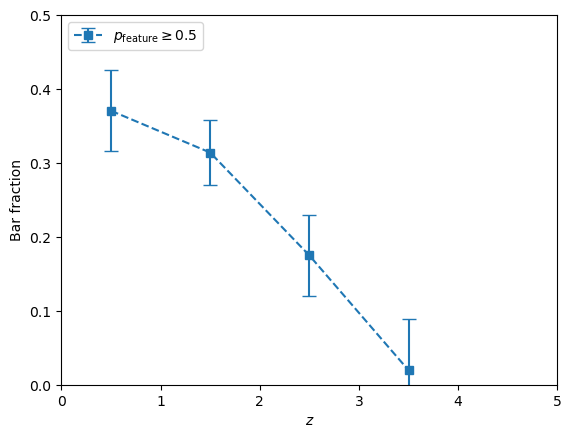

In [126]:
# different p_feature, binned by z
num_disks = np.zeros((1, N_BINS_z, N_RUNS))
num_barred_disks = np.zeros((1, N_BINS_z, N_RUNS))

sel = merged.query('zfit_50_y<5 & logM_50_y>10 & logM_50_y<11')

z50 = sel.zfit_50_y.values
feature_count = sel['feature_count'].values
edgeon_count = sel['edgeon_count'].values
bar_count = sel['bar_count'].values
q = sel['q'].values
id = sel['id'].values

for k in range(len(feature_thresholds)):
    for i in range(len(sel)):
        for j in range(N_BINS_z):
            if (z50[i] >= bins_z[j]) & (z50[i] < bins_z[j+1]):
                feature = str2array(feature_count[i])
                edgeon = str2array(edgeon_count[i])
                bar = str2array(bar_count[i])

                # is_disk = (feature >= 0.3*N_VOLS) & (edgeon <= 0.5*feature) & (q[i] >= 0.5)
                is_disk = (feature >= feature_thresholds[k]*N_VOLS) & (feature-edgeon >= 15) & (q[i] >= 0.5)
                num_disks[k,j,:] += is_disk.astype(int)

                is_barred_disk = is_disk & (bar >= 0.5*(feature-edgeon))
                num_barred_disks[k,j,:] += is_barred_disk.astype(int)
            
                break

bar_fraction = num_barred_disks / num_disks
err = np.sqrt(np.sum(bar_fraction*(1-bar_fraction)/num_disks, axis=2)/N_RUNS**2 + np.var(bar_fraction, axis=2))

bin_centers = [(bins_z[i] + bins_z[i+1]) / 2 for i in range(N_BINS_z)]

# plt.plot(bin_centers, np.mean(bar_fraction, axis=1), linestyle='-')
# plt.scatter(bin_centers, np.mean(bar_fraction, axis=1), marker='s')
plt.figure()
for k in range(len(feature_thresholds)):
    plt.errorbar(bin_centers, np.mean(bar_fraction[k,:,:], axis=1), yerr=err[k,:], 
                 fmt='--s', capsize = 5, 
                 label=r'$p_\mathrm{feature}\geq%.1f$'%feature_thresholds[k])
plt.xticks(bins_z)
plt.xlabel(r"$z$")
plt.ylabel("Bar fraction")
plt.ylim((0, 0.5))
plt.legend(loc='upper left')
#plt.savefig(f'F{FILTER}W_pred/f_bar_z_p_feature_F{FILTER}W.png')
plt.show()

(array([ 5.,  8.,  8.,  9., 23., 34., 31., 47., 33.,  7.]),
 array([17.9384 , 18.41411, 18.88982, 19.36553, 19.84124, 20.31695,
        20.79266, 21.26837, 21.74408, 22.21979, 22.6955 ]),
 <BarContainer object of 10 artists>)

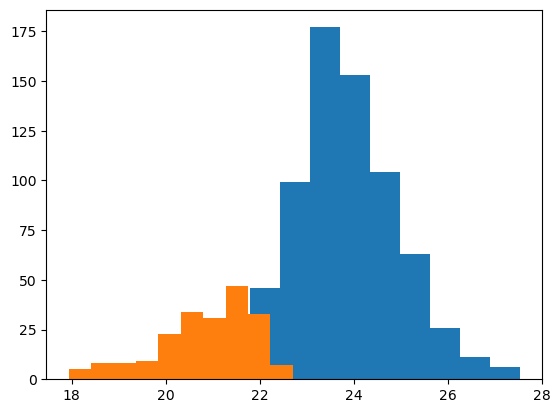

In [132]:
sel = merged.query('zfit_50_y>1.5 & logM_50_y>10 & logM_50_y<11')
plt.hist(sel.F150W_MAG)

sel = merged.query('zfit_50_y<1 & logM_50_y>10 & logM_50_y<11')
plt.hist(sel.F150W_MAG)

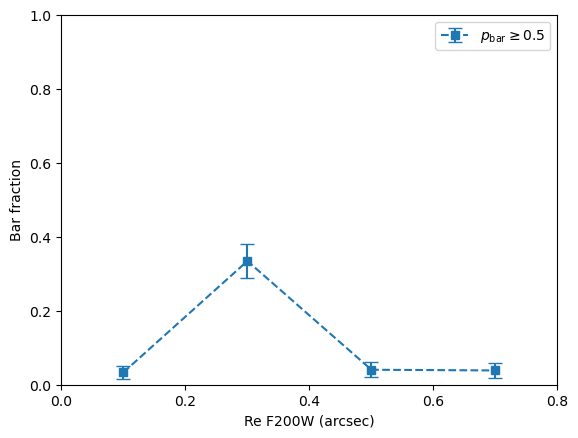

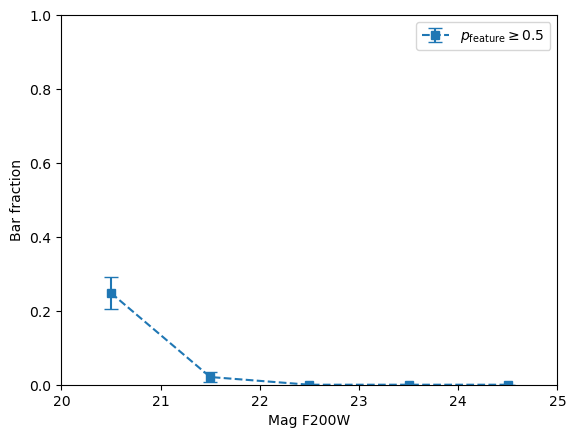

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define any missing functions or variables
def str2array(s):
    """Converts a string representation of an array into a numpy array."""
    # Remove square brackets and split by commas
    s = s.strip('[]')
    return np.fromstring(s, sep=',')

# Define constants
N_RUNS = 100  # Number of runs or volumes (adjust based on your data)
N_VOLS = N_RUNS

# Assuming 'merged' is your DataFrame containing the necessary data
# Apply selection criteria to the DataFrame
sel = merged.query('zfit_50_x < 1 & logM_50_x > 10 & logM_50_x < 12')

# Extract necessary columns from the DataFrame
feature_count = sel['feature_count'].values
edgeon_count = sel['edgeon_count'].values
bar_count = sel['bar_count'].values
q = sel['q'].values  # Assuming 'q' is a column in 'sel'

# Define bins for magnitude and effective radius
bins_mag = [20, 21, 22, 23, 24, 25]  # Magnitude bins
bins_Re = [0., 0.2, 0.4, 0.6, 0.8]    # Effective radius bins in arcseconds

# Extract magnitude and effective radius values
mag_F200W = sel['F150W_MAG'].values
Re_F200W = sel['F150W_RE'].values

# Define thresholds
feature_thresholds = [0.5]
bar_thresholds = [0.5]

# Function to compute bar fractions binned by effective radius
def compute_bar_fractions_Re(sel, bins_Re, Re_F200W, bar_thresholds, N_VOLS):
    N_BINS_Re = len(bins_Re) - 1
    num_disks = np.zeros((len(bar_thresholds), N_BINS_Re, N_VOLS))
    num_barred_disks = np.zeros((len(bar_thresholds), N_BINS_Re, N_VOLS))

    for k, bar_threshold in enumerate(bar_thresholds):
        for i in range(len(sel)):
            bin_value = Re_F200W[i]
            bin_idx = np.digitize(bin_value, bins_Re) - 1
            if 0 <= bin_idx < N_BINS_Re:
                # Convert string counts to arrays
                feature = str2array(feature_count[i])
                edgeon = str2array(edgeon_count[i])
                bar = str2array(bar_count[i])

                # Ensure arrays have length N_VOLS
                if feature.size != N_VOLS or edgeon.size != N_VOLS or bar.size != N_VOLS:
                    raise ValueError(f"Array lengths do not match N_VOLS at index {i}")

                # Determine if the object is a disk
                is_disk = (feature >= 0.3 * N_VOLS) & ((feature - edgeon) >= 15) & (q[i] >= 0.5)
                is_disk = is_disk.astype(int)

                # Update disk counts
                num_disks[k, bin_idx, :] += is_disk

                # Determine if the object is a barred disk
                is_barred_disk = is_disk & (bar >= bar_threshold * (feature - edgeon)).astype(int)
                num_barred_disks[k, bin_idx, :] += is_barred_disk

    # Compute bar fractions
    with np.errstate(divide='ignore', invalid='ignore'):
        bar_fraction = np.where(num_disks != 0, num_barred_disks / num_disks, 0)

    # Compute mean and error across N_VOLS
    mean_bar_fraction = np.nanmean(bar_fraction, axis=2)  # Mean over N_VOLS
    variance_bar_fraction = np.nanvar(bar_fraction, axis=2)
    err = np.sqrt(mean_bar_fraction * (1 - mean_bar_fraction) / N_VOLS)

    bin_centers = [(bins_Re[i] + bins_Re[i + 1]) / 2 for i in range(N_BINS_Re)]
    return mean_bar_fraction, err, bin_centers

# Function to compute bar fractions binned by magnitude
def compute_bar_fractions_mag(sel, bins_mag, mag_F200W, feature_thresholds, N_VOLS):
    N_BINS_mag = len(bins_mag) - 1
    num_disks = np.zeros((len(feature_thresholds), N_BINS_mag, N_VOLS))
    num_barred_disks = np.zeros((len(feature_thresholds), N_BINS_mag, N_VOLS))

    for k, feature_threshold in enumerate(feature_thresholds):
        for i in range(len(sel)):
            bin_value = mag_F200W[i]
            bin_idx = np.digitize(bin_value, bins_mag) - 1
            if 0 <= bin_idx < N_BINS_mag:
                # Convert string counts to arrays
                feature = str2array(feature_count[i])
                edgeon = str2array(edgeon_count[i])
                bar = str2array(bar_count[i])

                # Ensure arrays have length N_VOLS
                if feature.size != N_VOLS or edgeon.size != N_VOLS or bar.size != N_VOLS:
                    raise ValueError(f"Array lengths do not match N_VOLS at index {i}")

                # Determine if the object is a disk
                is_disk = (feature >= feature_threshold * N_VOLS) & ((feature - edgeon) >= 15) & (q[i] >= 0.5)
                is_disk = is_disk.astype(int)

                # Update disk counts
                num_disks[k, bin_idx, :] += is_disk

                # Determine if the object is a barred disk
                is_barred_disk = is_disk & (bar >= 0.5 * (feature - edgeon)).astype(int)
                num_barred_disks[k, bin_idx, :] += is_barred_disk

    # Compute bar fractions
    with np.errstate(divide='ignore', invalid='ignore'):
        bar_fraction = np.where(num_disks != 0, num_barred_disks / num_disks, 0)

    # Compute mean and error across N_VOLS
    mean_bar_fraction = np.nanmean(bar_fraction, axis=2)  # Mean over N_VOLS
    variance_bar_fraction = np.nanvar(bar_fraction, axis=2)
    err = np.sqrt(mean_bar_fraction * (1 - mean_bar_fraction) / N_VOLS)

    bin_centers = [(bins_mag[i] + bins_mag[i + 1]) / 2 for i in range(N_BINS_mag)]
    return mean_bar_fraction, err, bin_centers

# Compute bar fractions binned by effective radius
mean_bar_fraction_Re, err_Re, bin_centers_Re = compute_bar_fractions_Re(
    sel, bins_Re, Re_F200W, bar_thresholds, N_VOLS)

# Plot bar fraction vs. effective radius
plt.figure()
for k, bar_threshold in enumerate(bar_thresholds):
    plt.errorbar(bin_centers_Re, mean_bar_fraction_Re[k, :], yerr=err_Re[k, :],
                 fmt='--s', capsize=5,
                 label=r'$p_\mathrm{bar}\geq%.1f$' % bar_threshold)
plt.xticks(bins_Re)
plt.xlabel("Re F200W (arcsec)")
plt.ylabel("Bar fraction")
plt.ylim((0, 1.))
plt.legend(loc='upper right')
plt.show()

# Compute bar fractions binned by magnitude
mean_bar_fraction_mag, err_mag, bin_centers_mag = compute_bar_fractions_mag(
    sel, bins_mag, mag_F200W, feature_thresholds, N_VOLS)

# Plot bar fraction vs. magnitude
plt.figure()
for k, feature_threshold in enumerate(feature_thresholds):
    plt.errorbar(bin_centers_mag, mean_bar_fraction_mag[k, :], yerr=err_mag[k, :],
                 fmt='--s', capsize=5,
                 label=r'$p_\mathrm{feature}\geq%.1f$' % feature_threshold)
plt.xticks(bins_mag)
plt.xlabel("Mag F200W")
plt.ylabel("Bar fraction")
plt.ylim((0, 1.))
plt.legend(loc='upper right')
plt.show()


In [55]:
print(bar_fraction)

[[[nan nan 0.  0.  0.  nan 1.  1.  0.  0.  nan 0.  0.  0.  0.  0.  nan
   nan nan 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  nan 0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  nan
   0.  nan nan 0.  0.  0.  0.  0.  0.  nan nan 0.  0.  0.  0.  0.5 0.
   0.  0.  0.  0.  0.  nan 0.  0.  nan 0.  0.  0.  0.  nan 0.  0.  1.
   0.  0.  nan 0.  nan 0.  0.  nan 0.  0.  nan 0.  0.  nan 1. ]
  [nan 1.  0.  nan 0.  nan nan nan nan 0.  1.  0.  0.  nan nan 0.  nan
   nan 0.  0.  nan 0.  nan nan nan 0.  nan nan 0.  nan nan nan nan nan
   nan 0.  nan nan 0.5 nan nan nan nan nan nan 0.  0.  0.  0.  nan nan
   nan nan 0.  nan 0.  nan 0.  0.  0.  nan nan 0.  0.  0.  0.  0.  nan
   nan nan nan 0.  nan nan nan nan nan nan 0.  nan nan 0.  0.  0.  0.
   nan nan nan 0.  0.  0.  nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
   nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 0.
   nan nan nan nan nan na

In [ ]:
# Assuming merge is already defined as a DataFrame

# Handle NaN and infinity values by filling them with appropriate placeholder values
for col in merge.columns:
    if merge[col].dtype.kind in 'i':  # Integer columns
        merge[col] = merge[col].fillna(-999).replace([np.inf, -np.inf], -999)
    elif merge[col].dtype.kind in 'f':  # Float columns
        merge[col] = merge[col].fillna(-999.0).replace([np.inf, -np.inf], -999.0)
    elif isinstance(merge[col].iloc[0], (list, np.ndarray)):  # Nested arrays
        merge[col] = merge[col].apply(lambda x: fill_invalid_values(x, -999.0))

# Save DataFrame to CSV file in chunks
csv_path = os.path.join(cat_dir, 'merged_catalog_samples.csv')

chunk_size = 10000
for start in range(0, merge.shape[0], chunk_size):
#for start in range(0, chunk_size, chunk_size):
    end = min(start + chunk_size, merge.shape[0])
    chunk = merge.iloc[start:end]
    if start == 0:
        chunk.to_csv(csv_path, index=False, mode='w')
    else:
        chunk.to_csv(csv_path, index=False, mode='a', header=False)

print(f"DataFrame saved to CSV file: {csv_path}")

# Now, convert each chunk from the CSV file to a FITS file
def convert_csv_to_fits(csv_path, output_fits_path, chunk_size=10000):
    for chunk in pd.read_csv(csv_path, chunksize=chunk_size):
        # Convert chunk to Astropy Table
        chunk_table = Table.from_pandas(chunk)
        
        # Create FITS columns
        fits_columns = []
        for colname in chunk_table.colnames:
            col_data = chunk_table[colname]
            if isinstance(col_data[0], (list, np.ndarray)):
                data = np.array([np.array(x) for x in col_data], dtype='object')
                fits_columns.append(fits.Column(name=colname, format='PJ()', array=data))
            else:
                # Determine the format based on the dtype of the column
                if col_data.dtype == np.int32:
                    col_format = 'J'  # 32-bit integer
                elif col_data.dtype == np.float32:
                    col_format = 'E'  # 32-bit float
                elif col_data.dtype == np.int16:
                    col_format = 'I'  # 16-bit integer
                elif col_data.dtype.kind in {'U', 'S'}:  # String columns
                    max_len = max(len(str(x)) for x in col_data)
                    col_format = f'A{max_len}'
                else:
                    raise ValueError(f"Unsupported data type {col_data.dtype} for column {colname}")
                fits_columns.append(fits.Column(name=colname, format=col_format, array=col_data))

        # Create a FITS HDU from the FITS columns
        hdu = fits.BinTableHDU.from_columns(fits.ColDefs(fits_columns))

        # Write to FITS file
        if not os.path.exists(output_fits_path):
            hdu.writeto(output_fits_path, overwrite=True)
        else:
            with fits.open(output_fits_path, mode='append') as hdul:
                hdul.append(hdu)
                hdul.writeto(output_fits_path, overwrite=True)


# Write to FITS file
output_fits_path = os.path.join(cat_dir, 'COSMOSWeb_master_v2.0.1-sersic-cgs_LePhare-v2_FlaggedM_morphology_zoobot.fits')
convert_csv_to_fits(csv_path, output_fits_path, chunk_size=10000)
#hdu.writeto(output_fits_path, overwrite=True)


print(f"File saved to: {output_fits_path}")